<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

## XGBoost

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

import display_functions
import helper_functions
import model_functions

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = helper_functions.load_feather_as_df(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
525,17728,1,0.345098,0.392157,0.349020,0.347222,0.120000,0.392157,41.073028,-6.975674,...,0.121212,0.061008,18.755522,0.121579,0.063830,4.235294,0.379038,1.136360,1.123592,0.988761
303,6601,0,0.333333,0.372549,0.360784,0.450000,0.105263,0.372549,39.391656,-4.540439,...,0.113636,0.035422,18.770765,0.071534,0.055555,2.078431,0.363362,1.117644,1.032606,0.923910
128,6710,0,0.235294,0.266667,0.258824,0.458333,0.117647,0.266667,28.082601,-3.748466,...,0.129032,0.038168,18.774145,0.077353,0.062500,1.568627,0.259431,1.133329,1.030299,0.909087
361,6624,0,0.211765,0.262745,0.270588,0.522222,0.217391,0.270588,27.374989,-4.719287,...,0.249999,0.042802,18.771478,0.092878,0.107438,1.313725,0.252473,1.240735,0.971011,0.782606
97,17659,0,0.160784,0.176471,0.192157,0.583333,0.163265,0.192157,18.231814,-0.719670,...,0.108107,0.000000,18.788769,0.003966,0.046511,-0.392157,0.174268,1.097554,0.918363,0.836730


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


### Load XGBoost best model

In [8]:
xgboost_best_model_selected_path = os.path.join(project_models, "xgboost_best_model.pkl")
xgboost_best_model = model_functions.load_model(xgboost_best_model_selected_path)

## Análisis importancia de las variables empleadas en el modelo

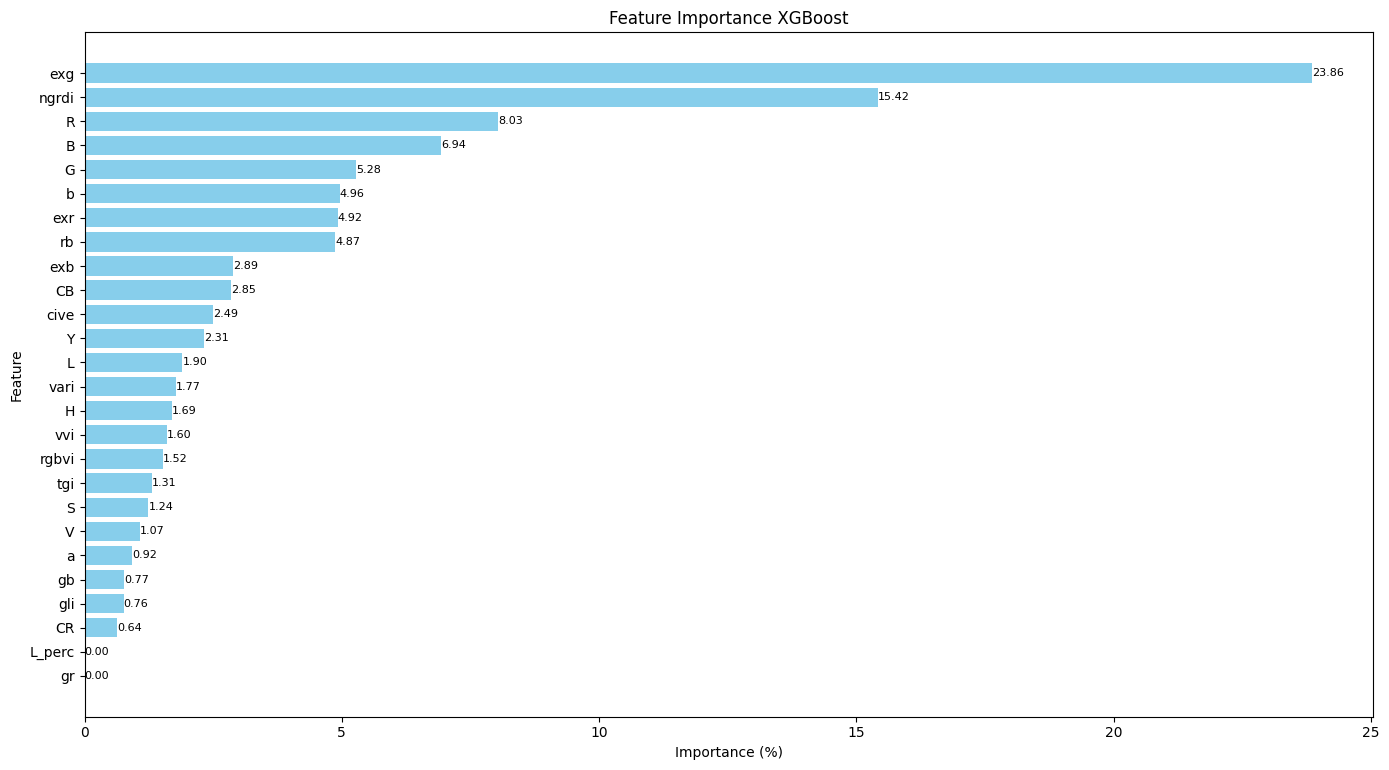

In [9]:
feature_names = X.columns
model_name = "XGBoost"

df_importances = model_functions.compute_feature_importance(xgboost_best_model, feature_names, model_name)

In [10]:
df_importances

,feature,importance,importance_pct
12,exg,0.238560,23.856031
20,ngrdi,0.154150,15.415014
0,R,0.080332,8.033233
2,B,0.069360,6.935952
1,G,0.052764,5.276376
8,b,0.049616,4.961599
13,exr,0.049200,4.919980
25,rb,0.048665,4.866491
14,exb,0.028921,2.892081
10,CB,0.028498,2.849762


In [11]:
# Calcular la importancia acumulada
df_importances["cum_importance"] = df_importances["importance"].cumsum()

# Seleccionar las variables necesarias para cubrir al menos el 90%
selected_features = df_importances[df_importances["cum_importance"] <= 0.90]["feature"].tolist()

# Incluir la primera variable que supera el 90% si no se ha incluido
if df_importances["cum_importance"].iloc[len(selected_features)] < 1.0:
    selected_features.append(df_importances["feature"].iloc[len(selected_features)])

# Calcular la importancia acumulada explicada por las variables seleccionadas
cum_explained = df_importances[df_importances["feature"].isin(selected_features)]["importance"].sum()

print("Variables seleccionadas:", selected_features)
print(f"Importancia acumulada explicada: {cum_explained*100:.2f}%")

Variables seleccionadas: ['exg', 'ngrdi', 'R', 'B', 'G', 'b', 'exr', 'rb', 'exb', 'CB', 'cive', 'Y', 'L', 'vari', 'H']
Importancia acumulada explicada: 90.18%


In [12]:
total_variable_names = data.columns

dropped_features = [name for name in list(set(total_variable_names) ^ set(selected_features)) if name not in ["sample_id","label"]]  # ^ es XOR: elementos en uno u otro, pero no en ambos
print("Variables eliminadas: ", dropped_features)  # aparece "sample_id" y "label", que no hay que considerarlas

Variables eliminadas:  ['S', 'rgbvi', 'a', 'L_perc', 'gb', 'CR', 'gli', 'gr', 'tgi', 'V', 'vvi']


In [13]:
df_selected = data.drop(columns=dropped_features)

In [14]:
df_selected

,sample_id,label,R,G,B,H,L,b,Y,CB,exg,exr,exb,vari,cive,ngrdi,rb
0,17679,0,0.101961,0.160784,0.160784,0.500000,15.305140,-2.034145,47.359941,130.223353,0.058824,-0.018039,0.058824,0.576917,18.763471,0.223880,0.634142
1,6623,0,0.407843,0.423529,0.403922,0.300000,45.147446,2.263262,107.236259,126.396816,0.035294,0.147451,-0.023529,0.036697,18.778886,0.018868,1.009706
2,197,1,0.380392,0.396078,0.372549,0.277778,42.269328,2.858058,101.126588,125.957600,0.039216,0.136471,-0.031373,0.038835,18.776965,0.020202,1.021050
3,17600,0,0.419608,0.474510,0.450980,0.428571,49.542282,1.528755,115.735176,127.439835,0.078431,0.112941,0.007843,0.123894,18.760847,0.061403,0.930433
4,17556,0,0.054902,0.113725,0.125490,0.527778,9.611652,-4.077139,37.347776,131.541000,0.047059,-0.036863,0.082353,1.363605,18.767294,0.348835,0.437497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,17867,1,0.501961,0.529412,0.482353,0.263889,55.428130,5.568581,128.968788,123.766976,0.074510,0.173333,-0.066667,0.050000,18.764718,0.026616,1.040648
563,28753,0,0.282353,0.294118,0.301961,0.566667,31.682841,-1.610755,79.837212,129.323102,0.003922,0.101176,0.027451,0.042857,18.789243,0.020408,0.935062
564,17763,1,0.372549,0.411765,0.360784,0.294872,43.224699,6.023817,102.335812,123.772431,0.090196,0.109804,-0.062745,0.092592,18.756255,0.050000,1.032606
565,17790,0,0.341176,0.380392,0.360784,0.416667,40.160845,1.532789,96.248471,127.286157,0.058824,0.097255,0.000000,0.108695,18.767863,0.054348,0.945650


In [15]:
df_selected.describe()

,sample_id,label,R,G,B,H,L,b,Y,CB,exg,exr,exb,vari,cive,ngrdi,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,36.823065,3.727633,90.405431,125.267049,0.052550,0.110389,-0.041961,0.098274,18.770834,0.043530,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,13.412162,6.402374,27.698344,5.359219,0.035777,0.075339,0.102659,0.137972,0.013241,0.054708,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,7.438742,-7.518066,34.230247,105.594545,-0.043137,-0.047843,-0.423529,-0.153846,18.717208,-0.098182,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,27.078731,-0.772790,70.308565,123.031314,0.031373,0.058039,-0.082353,0.021016,18.763414,0.011494,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,35.882136,2.722082,87.804518,126.264957,0.047059,0.093333,-0.019608,0.081967,18.771643,0.042105,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,44.579033,6.596413,105.667618,129.180333,0.074510,0.147451,0.031373,0.155050,18.778433,0.073529,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,83.894231,26.097241,193.852906,133.731624,0.188235,0.365490,0.117647,1.363605,18.812741,0.358489,1.737494


## Entrenamiento con las variables seleccionadas

### Evaluación del modelo con los atributos seleccionados

In [16]:
X = df_selected.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 15)
(567,)


### Hold-out externo

In [17]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

### Hold-out interno

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(362, 15)
(362,)
(91, 15)
(91,)
(114, 15)
(114,)


In [20]:
xgb_base = XGBClassifier(
    objective='binary:logistic' if len(np.unique(y)) == 2 else 'multi:softprob',
    num_class=len(np.unique(y)), 
    eval_metric=["mlogloss","auc","logloss"],  #  loglossestable para GridSearch
    tree_method="hist",                # rápido y estable, especialmente en MacOS
    n_estimators=400,                  # alto + early stopping si se usa
    subsample=0.8,                     # reduce overfitting
    colsample_bytree=0.8,              # importante con índices correlados
    random_state=42,
    n_jobs=1,                          # usar solo un hilo evita segfault en MacOs
    nthread=1,           # evitar segfaults
    use_label_encoder=False,
    verbosity=0 # 0 = silencioso; 1 = información básica; 2 = más detallado
)

Grid de hiperparámetros

In [21]:
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 6, 8, 10],
    'learning_rate': [0.05, 0.1], # 0.05 bajo → mejor generalización
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [0, 0.5, 1],
}

GridSearchCV 

In [22]:
cv_xgb_selected = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='f1_weighted',  # o "balanced_accuracy"
    n_jobs=1,               # evita paralelismo problemático en McOS
    verbose=2,
    refit=True,
    error_score='raise',
    pre_dispatch='1*n_jobs'
)

In [23]:
fit_params = {
    "eval_set": [(X_val, y_val)],
    "early_stopping_rounds": 20,
    "eval_metric":  "f1_macro",  # "logloss"
    "verbose": False
}

In [24]:
sample_weight = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [25]:
cv_xgb_selected.fit(X_train, y_train, sample_weight=sample_weight)
print("Mejores parámetros:", cv_xgb_selected.best_params_)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1; total t

In [26]:
xgboost_best_model_selected = cv_xgb_selected.best_estimator_

Entrenar modelo final con early stopping

In [27]:
xgboost_final_model_selected = XGBClassifier(
    **cv_xgb_selected.best_params_,
    use_label_encoder=False,
    eval_metric="mlogloss" if len(np.unique(y_train)) > 2 else "logloss", # multiclase or 
    early_stopping_rounds=20,
    random_state=42
)

In [28]:
xgboost_final_model_selected.fit(
    X_train, y_train,
    sample_weight=sample_weight,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mlogloss:1.02310
[1]	validation_0-mlogloss:0.94985
[2]	validation_0-mlogloss:0.88830
[3]	validation_0-mlogloss:0.83415
[4]	validation_0-mlogloss:0.78610
[5]	validation_0-mlogloss:0.74470
[6]	validation_0-mlogloss:0.70686
[7]	validation_0-mlogloss:0.67200
[8]	validation_0-mlogloss:0.64159
[9]	validation_0-mlogloss:0.61324
[10]	validation_0-mlogloss:0.58994
[11]	validation_0-mlogloss:0.56544
[12]	validation_0-mlogloss:0.54465
[13]	validation_0-mlogloss:0.52374
[14]	validation_0-mlogloss:0.50445
[15]	validation_0-mlogloss:0.48701
[16]	validation_0-mlogloss:0.47141
[17]	validation_0-mlogloss:0.45699
[18]	validation_0-mlogloss:0.44382
[19]	validation_0-mlogloss:0.43110
[20]	validation_0-mlogloss:0.42051
[21]	validation_0-mlogloss:0.41054
[22]	validation_0-mlogloss:0.40177
[23]	validation_0-mlogloss:0.39305
[24]	validation_0-mlogloss:0.38485
[25]	validation_0-mlogloss:0.37815
[26]	validation_0-mlogloss:0.37155
[27]	validation_0-mlogloss:0.36585
[28]	validation_0-mlogloss:0.3

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mlogloss'


Evaluación final en test

In [29]:
y_pred = xgboost_final_model_selected.predict(X_test)

Métricas

In [30]:
mse,rmse,r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.12280701754385964
RMSE:  0.3504383220252312
R²:    0.6649874055415617
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        73
           1       0.78      0.82      0.80        34
           2       0.57      0.57      0.57         7

    accuracy                           0.88       114
   macro avg       0.77      0.78      0.77       114
weighted avg       0.88      0.88      0.88       114

[[68  5  0]
 [ 3 28  3]
 [ 0  3  4]]


Matriz de confusión

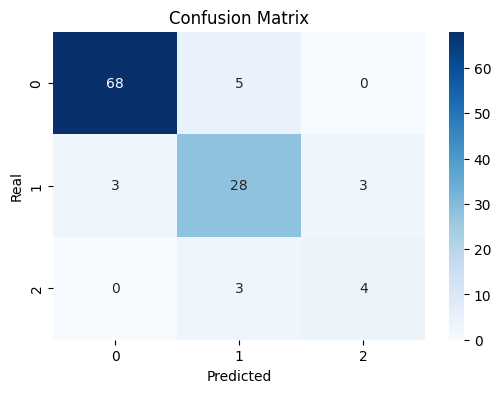

In [31]:
display_functions.plot_confusion_matrix(conf_matrix)

### Ploteamos la curva ROC

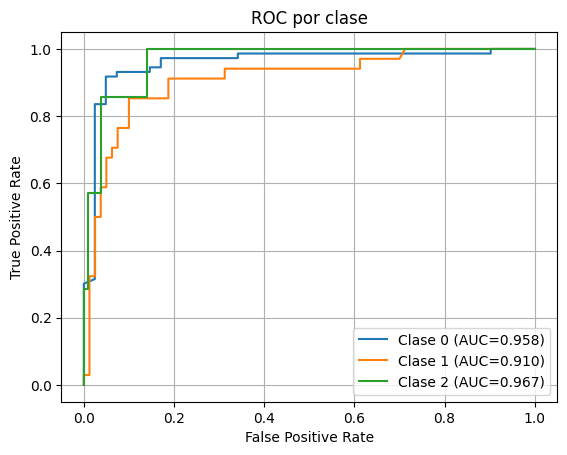

In [32]:
display_functions.plot_roc_curve(xgboost_best_model_selected,X_test, y_test)

## Save XGBoost best model after atribute selecction

In [33]:
xgboost_best_model_selected_path = os.path.join(project_models, "xgboost_best_model_feature_importance.pkl")

model_functions.save_model(xgboost_best_model_selected, xgboost_best_model_selected_path)

### Nota: Las métricas son las mismas. Solo hay ligeras diferencias en las curvas ROC.